In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu as mwu, tmean as mean
sns.set(style="darkgrid")

Please specifiy the location of the CSV file that Pyexec created

In [2]:
data = pd.read_csv("/home/michael/stats2.csv")
data = data.replace([-1], pd.NA)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15198 entries, 0 to 15197
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       15198 non-null  object 
 1   project_on_pypi            15198 non-null  bool   
 2   github_link_found          15198 non-null  bool   
 3   github_repo_exists         15198 non-null  bool   
 4   github_repo_created_at     15198 non-null  object 
 5   github_repo_last_updated   15198 non-null  object 
 6   github_repo_active_days    8846 non-null   float64
 7   github_repo_age            8846 non-null   float64
 8   has_setuppy                15198 non-null  bool   
 9   has_requirementstxt        15198 non-null  bool   
 10  has_makefile               15198 non-null  bool   
 11  has_pipfile                15198 non-null  bool   
 12  loc                        8916 non-null   float64
 13  num_impl_files             9009 non-null   flo

In [3]:
def pypi() -> DataFrame:
    return data[data["project_on_pypi"]]

def link() -> DataFrame:
    return data[data["github_link_found"]]

def mined() -> DataFrame:
    return data[data["github_repo_exists"]]

def testsuit() -> DataFrame:
    return mined()[mined()["testcase_count"] > 0]
 
def testsuit_but_no_success() -> DataFrame:
    return testsuit()[testsuit()["testsuit_result_parsed"] == False]
        
def inferred() -> DataFrame:
    return mined()[mined()["dockerfile_found"]]

def build(*, complement=False) -> DataFrame:
    return mined()[mined()["dockerimage_build_success"] != complement]

def executed() -> DataFrame:
    return build()[build()["testsuit_executed"]]
                   
def executed_but_no_success() -> DataFrame:
    return executed()[executed()["testsuit_result_parsed"] == False]
                   
def success() -> DataFrame:
    return mined()[mined()["testsuit_result_parsed"]]

hor = ["v2", "Pipfile", "setup.py", "requirements.txt", "None"]

# Summary statistics
Total number of times a project has reached some stage.
Good to have as a sanity-check.

In [5]:
print("Attempted: {}".format(len(data)))
print("Found on PyPI: {}".format(len(pypi())))
print("GitHub link found: {}".format(len(link())))
print("Mined: {}".format(len(mined())))
print("Has setup.py: {}".format(len(mined()[mined()["has_setuppy"]])))
print("Has Pipfile: {}".format(len(mined()[mined()["has_pipfile"]])))
print("Has requirements.txt: {}".format(len(mined()[mined()["has_requirementstxt"]])))
print("Has testsuit: {}".format(len(testsuit())))
print("Dockerimage inferred: {}".format(len(inferred())))
print("Dockerimage build success: {}".format(len(build())))
print("Testsuits executed: {}".format(len(executed())))
print("Testcases executed and parsed: {}".format(len(success())))

Attempted: 15198
Found on PyPI: 14875
GitHub link found: 9911
Mined: 9009
Has setup.py: 7870
Has Pipfile: 289
Has requirements.txt: 2837
Has testsuit: 1891
Dockerimage inferred: 5722
Dockerimage build success: 4747
Testsuits executed: 977
Testcases executed and parsed: 689


# RQ1: Fraction of projects for which an environment is inferred
Based on the number of project for which a GitHub link has been found and which cound be cloned.
Only projects for which a dockerfile has been inferred and for which a dockerimage was build successfully are counted here.

In [6]:
print("{}%".format(len(build()) / len(mined()) * 100))

52.69175269175269%


# RQ2: Fraction of projects for which the testcases could be executed
Based on the number of projects for which a dockerimage could be build

In [7]:
print("Fraction of projects for which a testsuit was detected and executed: {}%".format(len(executed()) / len(build()) * 100))
print("Fraction of projects for which testsuit execution was successful: {}%".format(len(success()) / len(build()) * 100))

Fraction of projects for which a testsuit was detected and executed: 20.58141984411207%
Fraction of projects for which testsuit execution was successful: 14.514430166420897%


So the ratio of successful testcase executions to all testsuit executions is:

In [8]:
print("\t{}%".format(len(success()) / len(executed()) * 100))

	70.52200614124871%


# RQ3 Representativness of project for which a environment has been found

The depency interferrance step should not damage the reprentativenss for all (mined) Python projects.
To evaluate whether this property holds the distribtutions for 
* lines of code (LOC)
* number of Python implementation files
* average cyclomatic complexity
* test-case count
* minmum required Python version
* active days and
* project age 

are chosen for comparison.
Hereby Python implementation files means Python files that contain code implementing some feature.
This exculde test code, \__init__.py files and setup.py files. This is done so differnce in the actual number of Python files are not caused by one pronect haveing a (bigger) testsuit or more sub-packages.

To get a feel for the distributions they are represented as a graph down below.
Additionally the source of the inferred dependencys (V2, Pipfile, requirements.txt or None if they could not be inferred) per project is represented here.

Whenever a value is not present (for example the cyclomatic complexity is missing for some project), that is the value is NaN ("Not a number") it is ignored. This can reduce the number of datapoits used per graph, so as a santiy check the number of datapoints for graph is provided for every graph.

First of all the graphs for all mined projects:

Datapoints: 8916


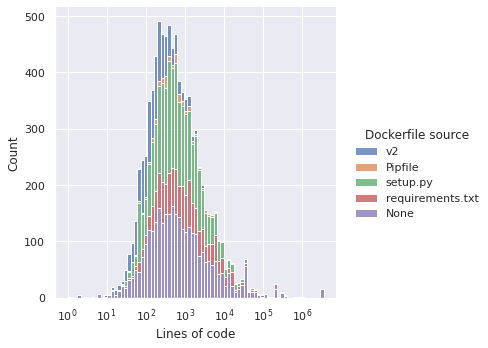

In [9]:
print("Datapoints: {}".format(len(mined()["loc"].dropna())))
g = sns.displot(mined(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 9009


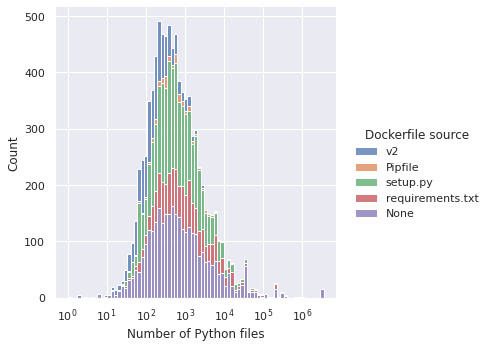

In [10]:
print("Datapoints: {}".format(len(mined()["num_impl_files"].dropna())))
g = sns.displot(mined(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 8680


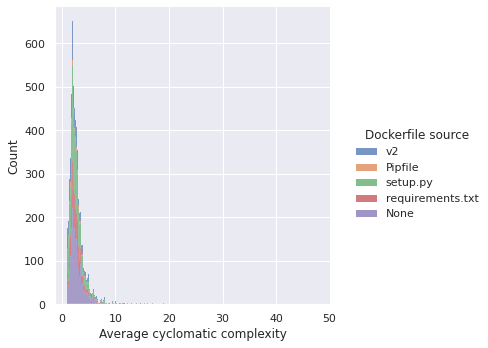

In [11]:
print("Datapoints: {}".format(len(mined()["average_complexity"].dropna())))
g = sns.displot(mined(), x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity")

For this plot there seem to be some noise.
To obatin a better view complexity values will be cut of at 10, for all plot showing the average cycomatic complexity.

Datapoints: 8680


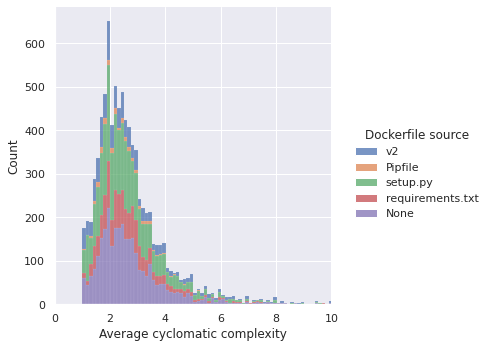

In [12]:
print("Datapoints: {}".format(len(mined()["average_complexity"].dropna())))
g = sns.displot(mined(), x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity", xlim=(0,10))

Datapoints: 1928


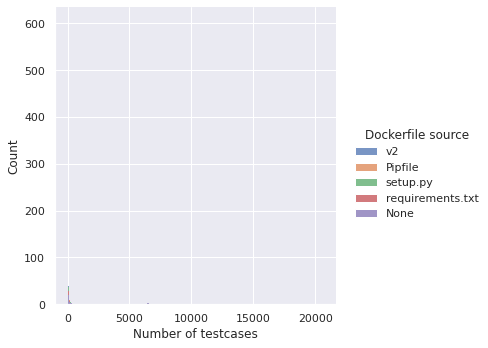

In [13]:
print("Datapoints: {}".format(len(mined()["testcase_count"].dropna())))
g = sns.displot(mined(), x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of testcases")

Datapoints: 1928


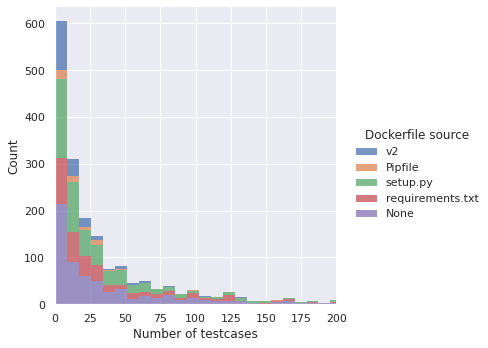

In [14]:
print("Datapoints: {}".format(len(mined()["testcase_count"].dropna())))
g = sns.displot(mined(), x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of testcases", xlim=(0,200))

Datapoints: 3648


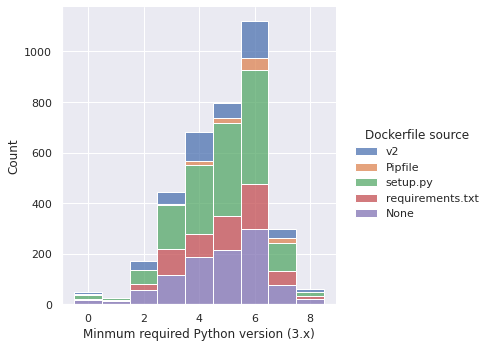

In [15]:
print("Datapoints: {}".format(len(mined()["min_python_version"].dropna())))
g = sns.displot(mined(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 8841


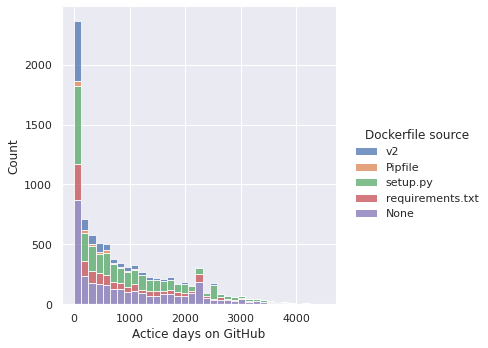

In [16]:
print("Datapoints: {}".format(len(mined()["github_repo_active_days"].dropna())))
g = sns.displot(mined(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 8841


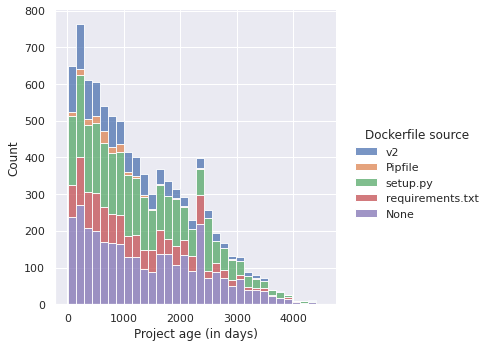

In [17]:
print("Datapoints: {}".format(len(mined()["github_repo_age"].dropna())))
g = sns.displot(mined(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

An interesting observation hereby is shown in the following graph. It suggests that there is a correlation betweeen the repository age and the mimum required Python version: The new a Project the newer the minimum required Python version.

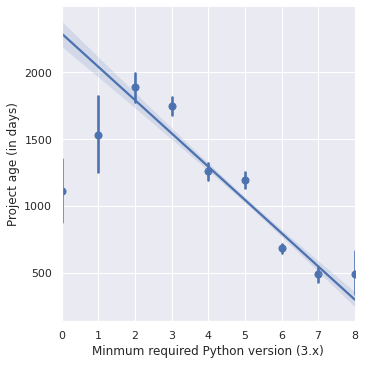

In [18]:
g = sns.lmplot(data=mined(), x="min_python_version", y="github_repo_age", x_estimator=np.mean)
g.set(xlabel="Minmum required Python version (3.x)", ylabel="Project age (in days)")

Next, the same graphs, but only taking projects into account for which dependencies cound be successfully inffered and for which a Dockerimage could be build:

Datapoints: 4747


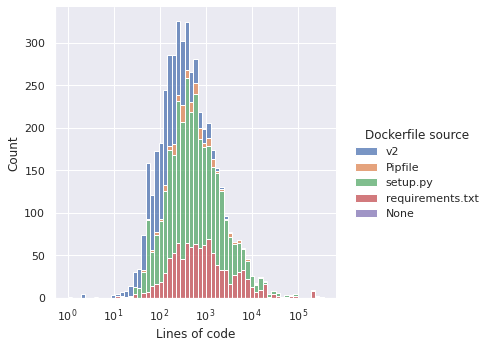

In [19]:
print("Datapoints: {}".format(len(build()["loc"].dropna())))
g = sns.displot(build(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack", log_scale=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 4747


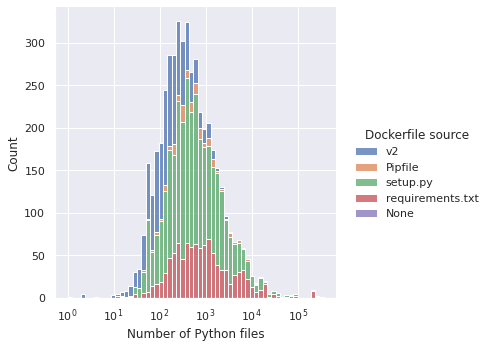

In [20]:
print("Datapoints: {}".format(len(build()["num_impl_files"].dropna())))
g = sns.displot(build(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 4681


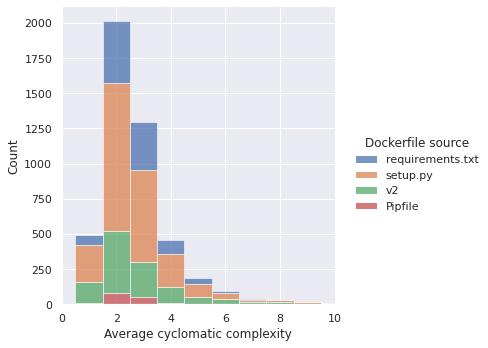

In [21]:
print("Datapoints: {}".format(len(build()["average_complexity"].dropna())))
g = sns.displot(build(), discrete=True, x="average_complexity", hue="dockerfile_source", multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity", xlim=(0,10))

Datapoints: 977


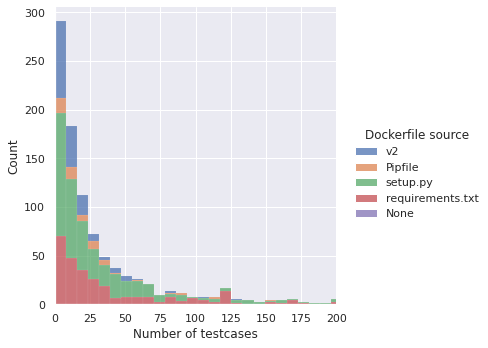

In [22]:
print("Datapoints: {}".format(len(build()["testcase_count"].dropna())))
g = sns.displot(build(), x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of testcases", xlim=(0,200))

Datapoints: 2234


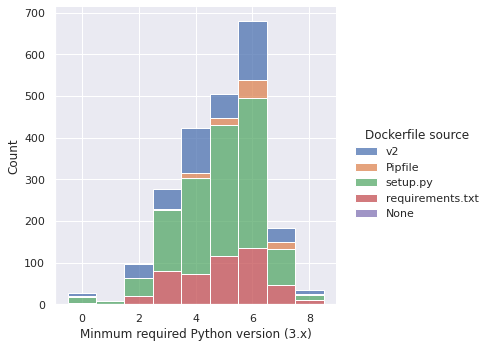

In [23]:
print("Datapoints: {}".format(len(build()["min_python_version"].dropna())))
g = sns.displot(build(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 4657


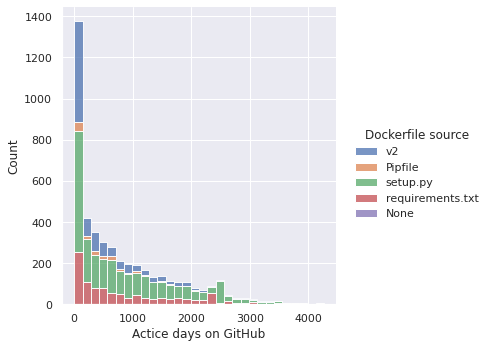

In [24]:
print("Datapoints: {}".format(len(build()["github_repo_active_days"].dropna())))
g = sns.displot(build(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 4657


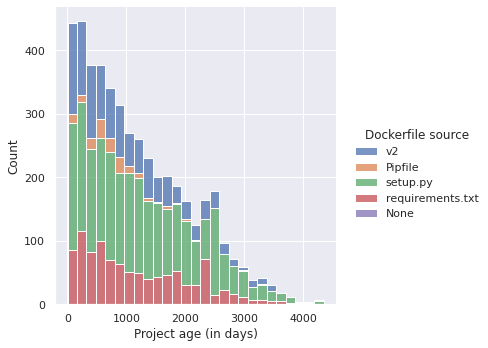

In [25]:
print("Datapoints: {}".format(len(build()["github_repo_age"].dropna())))
g = sns.displot(build(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

To test whether the distributions for these five properties are similar betweeen all mined projects and all proejcts for which dependencies could be infered and a Dockerimage be build the Mann-Whitney U-test is used:

In [26]:
print("LOC p-value: {}".format(mwu(build(complement=True)["loc"].dropna(), build()["loc"].dropna(), alternative="two-sided")[1]))
print("Num code files p-value: {}".format(mwu(build(complement=True)["num_impl_files"].dropna(), build()["num_impl_files"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(build(complement=True)["average_complexity"].dropna(), build()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Testcase count p-value: {}".format(mwu(build(complement=True)["testcase_count"].dropna(), build()["testcase_count"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(build(complement=True)["min_python_version"].dropna(), build()["min_python_version"].dropna(), alternative="two-sided")[1]))
print("Active days p-value: {}".format(mwu(build(complement=True)["github_repo_active_days"].dropna(), build()["github_repo_active_days"].dropna(), alternative="two-sided")[1]))
print("Age p-value: {}".format(mwu(build(complement=True)["github_repo_age"].dropna(), build()["github_repo_age"].dropna(), alternative="two-sided")[1]))

LOC p-value: 1.4585057182794227e-51
Num code files p-value: 6.327215615766079e-34
Complexity p-value: 3.2195604588192303e-06
Testcase count p-value: 3.445919472606783e-06
Version p-value: 0.632808381338418
Active days p-value: 2.6328088354634263e-15
Age p-value: 8.072773449487456e-18


## Effectiveness of the individual dependency inferrance apporaches

This section investigates how successful each of the approaches for dependency inferrence is.

That is not how many dockerfiels could be inferred by each approach.
Because the order in which the approaches are applied (v2 -> Pipfile -> Setup.py -> requirements.txt) is set and later apporaches are not attempted when a previouse apporach was successful considering how many Dockerimage wer found is only meaningful for v2.
However, we still can observe the ratio of successfully build to inferred Dockerfiles for each approach.

Moreover it would be interesting to investigate if the change a dockerimage is found, respectively is build successfully depends on the variouse properties listed above. However, because the differnt approaches are only applied in a certain order this only meaningful for v2. Luckily this is also the most interesting case.

### Ratio of successfuly build docker images

The ratio for each approach is based on the number of dockerfiles inferred

In [27]:
for s in ["v2", "Pipfile", "setup.py", "requirements.txt"]:
    print("For {}: {}%".format(s, len(build()[build()["dockerfile_source"] == s]) / len(inferred()[inferred()["dockerfile_source"] == s]) * 100))

For v2: 93.45637583892618%
For Pipfile: 91.01123595505618%
For setup.py: 81.37516688918558%
For requirements.txt: 76.17994100294986%


Moreover the absolute counts for v2 are

In [28]:
print("Inferred: {}".format(len(inferred()[inferred()["dockerfile_source"] == "v2"])))
print("That is {}% of all mined projects".format(len(inferred()[inferred()["dockerfile_source"] == "v2"]) / len(mined()) * 100))
print("Build: {}".format(len(build()[build()["dockerfile_source"] == "v2"])))
print("That is {}% of all mined projects".format(len(build()[build()["dockerfile_source"] == "v2"]) / len(mined()) * 100))

Inferred: 1192
That is 13.231213231213232% of all mined projects
Build: 1114
That is 12.365412365412364% of all mined projects


Additionally inspect whether the chance v2 inferres a Dockerfile depends on the variouse properties.
We will exploere these in greate detail.
For this the propeties
* Lines of Code
* Number of python files
* Code complexity

will be considered

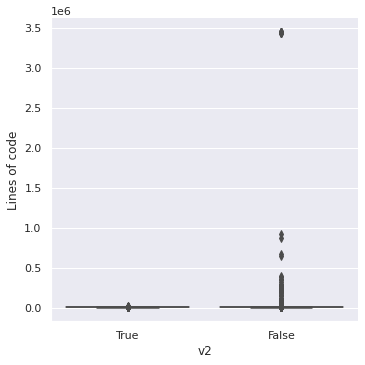

In [29]:
_m = mined().copy()
_m["v2"] =  _m["dockerfile_source"] == "v2"
g = sns.catplot(data=_m, x="v2",y="loc", order=[True, False], kind="box")
g.set(ylabel="Lines of code")

Limiting the y-axis to 5000 LOCs yields a better view

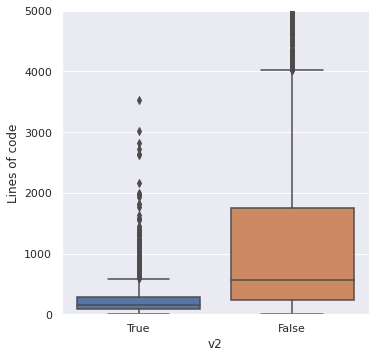

In [30]:
_m = mined().copy()
_m["v2"] =  _m["dockerfile_source"] == "v2"
g = sns.catplot(data=_m, x="v2",y="loc", order=[True, False], kind="box")
g.set(ylabel="Lines of code", ylim=(0,5000))

[Text(0, 0.5, 'Average complexity'), (0.0, 10.0)]

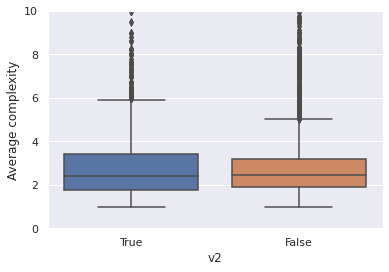

In [31]:
g = sns.boxplot(data=_m, x="v2", order=[True, False],y="average_complexity")
g.set(ylabel="Average complexity", ylim=(0,10))

[Text(0, 0.5, 'Number of Python code files')]

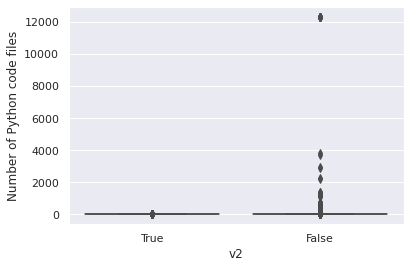

In [32]:
g = sns.boxplot(data=_m, x="v2", order=[True, False],y="num_impl_files")
g.set(ylabel="Number of Python code files")

[Text(0, 0.5, 'Number of Python code files'), (0.0, 30.0)]

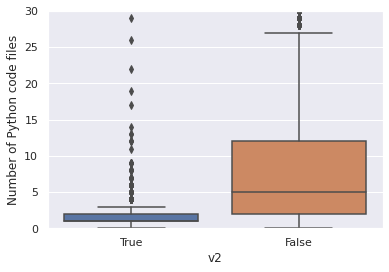

In [33]:
g = sns.boxplot(data=_m, x="v2", order=[True, False],y="num_impl_files")
g.set(ylabel="Number of Python code files", ylim=(0,30))

To get a bit more insight it might be interesting to inspect these properties not individually, but in relation to another:

Additionally it might be interesting to view the impact of test code files for this.
This is because we do not expect test files to contain any additional dependencies.
However, in practice exluding the test suit files from v2 led to failure of testsuit execution.

Zomming in in the lower left corner:

# RQ4 Representativness of project for testcases were exectued successfully

## Comparing to all mined projects

Ulitmatly the goal is for all project for which test cases were executed successfully to be representative for all Python proejects. More precisely, former project should be representative for all Python project, which have test cases. This filtering step needs to be accounted for. So, first the distribution of the five propertys are inspected for all mined project for which a testsuit was detected, then for all projects which testsuit has been executed successfully.


Datapoints: 1891


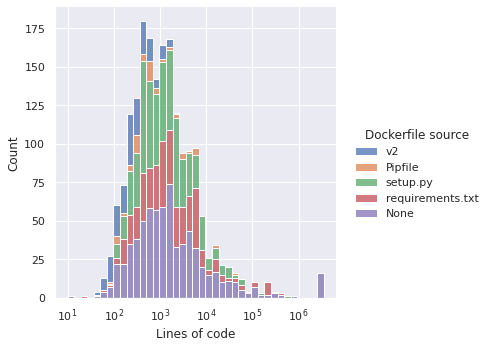

In [34]:
print("Datapoints: {}".format(len(testsuit()["loc"].dropna())))
g = sns.displot(testsuit(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack", log_scale=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 1889


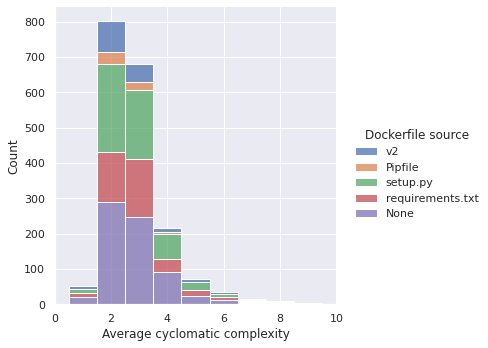

In [35]:
print("Datapoints: {}".format(len(testsuit()["average_complexity"].dropna())))
g = sns.displot(testsuit(), discrete=True, x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity", xlim=(0,10))

Datapoints: 1891


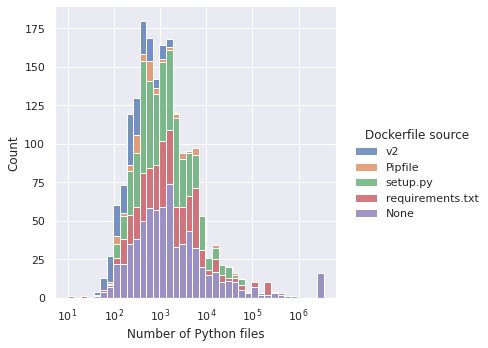

In [36]:
print("Datapoints: {}".format(len(testsuit()["num_impl_files"].dropna())))
g = sns.displot(testsuit(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 1891


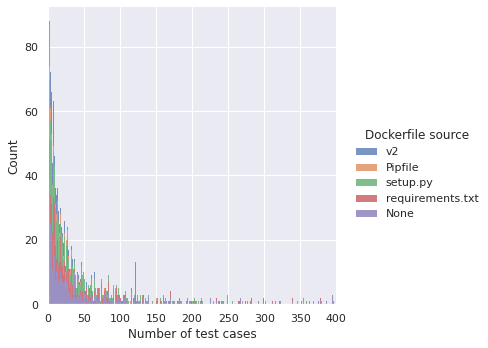

In [37]:
print("Datapoints: {}".format(len(testsuit()["testcase_count"].dropna())))
g = sns.displot(testsuit(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of test cases", xlim=(0,400))

Datapoints: 1054


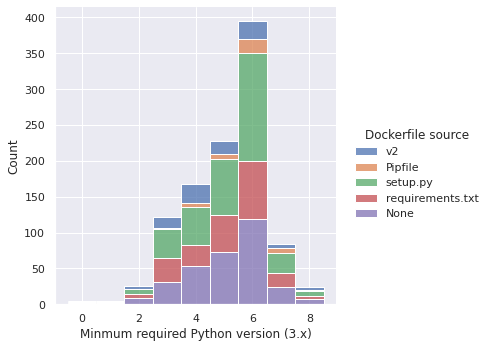

In [38]:
print("Datapoints: {}".format(len(testsuit()["min_python_version"].dropna())))
g = sns.displot(testsuit(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 1872


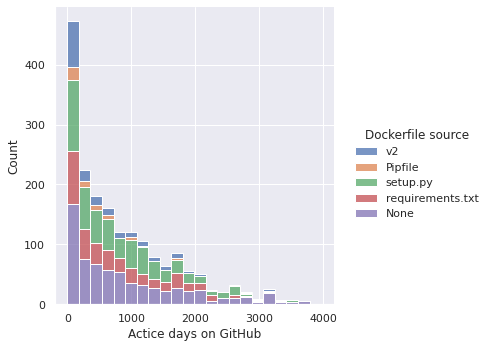

In [39]:
print("Datapoints: {}".format(len(testsuit()["github_repo_active_days"].dropna())))
g = sns.displot(testsuit(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 1872


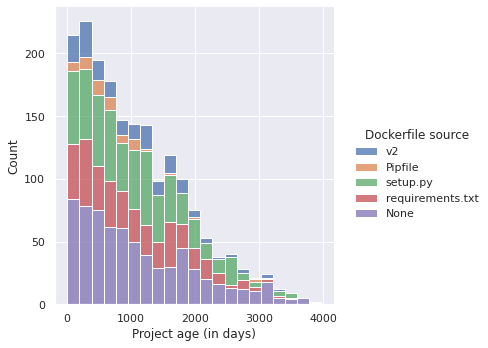

In [40]:
print("Datapoints: {}".format(len(testsuit()["github_repo_age"].dropna())))
g = sns.displot(testsuit(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Next, consider the same distributions for all projects which test cases have been executed successfully

Datapoints: 689


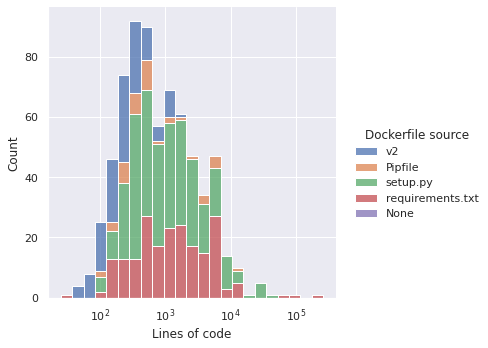

In [41]:
print("Datapoints: {}".format(len(success()["loc"].dropna())))
g = sns.displot(success(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack", log_scale=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 689


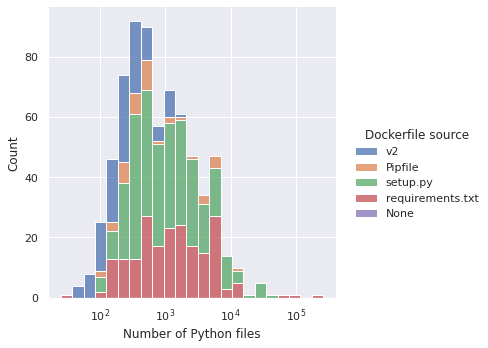

In [42]:
print("Datapoints: {}".format(len(success()["num_impl_files"].dropna())))
g = sns.displot(success(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Python files")

Datapoints: 689


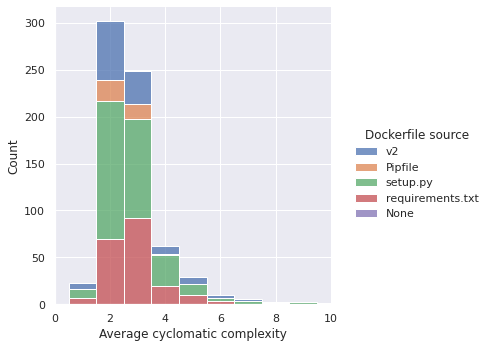

In [43]:
print("Datapoints: {}".format(len(success()["average_complexity"].dropna())))
g = sns.displot(success(), discrete=True, x="average_complexity", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity", xlim=(0,10))

Datapoints: 689


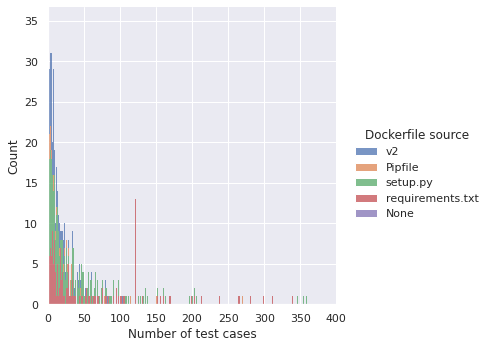

In [44]:
print("Datapoints: {}".format(len(success()["testcase_count"].dropna())))
g = sns.displot(success(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack"
           )
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of test cases", xlim=(0,400))

Datapoints: 434


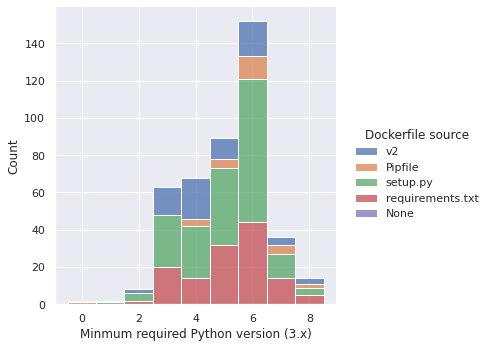

In [45]:
print("Datapoints: {}".format(len(success()["min_python_version"].dropna())))
g = sns.displot(success(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 681


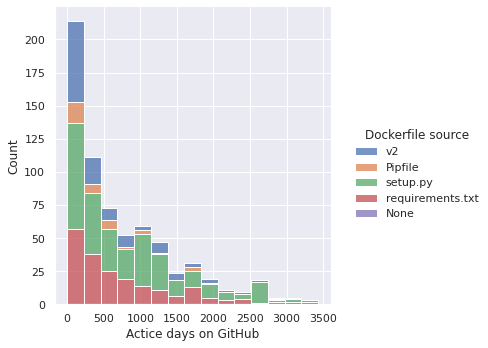

In [46]:
print("Datapoints: {}".format(len(success()["github_repo_active_days"].dropna())))
g = sns.displot(success(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 681


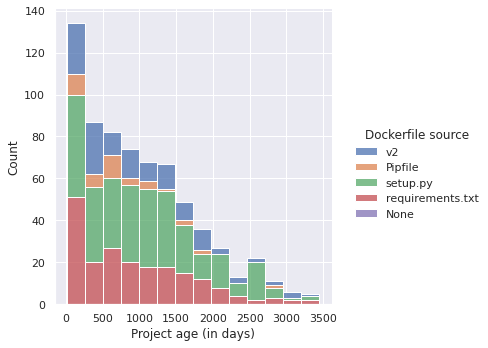

In [47]:
print("Datapoints: {}".format(len(success()["github_repo_age"].dropna())))
g = sns.displot(success(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Lets have a look at the resuls of the Mann-Whitney U-Test for these variables

In [48]:

print("LOC p-value: {}".format(mwu(testsuit_but_no_success()["loc"].dropna(), success()["loc"].dropna(), alternative="two-sided")[1]))
print("Num code files p-value: {}".format(mwu(testsuit_but_no_success()["num_impl_files"].dropna(), success()["num_impl_files"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(testsuit_but_no_success()["average_complexity"].dropna(), success()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Testcase count p-value: {}".format(mwu(testsuit_but_no_success()["testcase_count"].dropna(), success()["testcase_count"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(testsuit_but_no_success()["min_python_version"].dropna(), success()["min_python_version"].dropna(), alternative="two-sided")[1]))
print("Active days p-value: {}".format(mwu(testsuit_but_no_success()["github_repo_active_days"].dropna(), success()["github_repo_active_days"].dropna(), alternative="two-sided")[1]))
print("Age p-value: {}".format(mwu(testsuit_but_no_success()["github_repo_age"].dropna(), success()["github_repo_age"].dropna(), alternative="two-sided")[1]))

LOC p-value: 1.1904520512134695e-15
Num code files p-value: 1.8752835431939637e-14
Complexity p-value: 0.061249258550793224
Testcase count p-value: 3.921183171356603e-06
Version p-value: 0.47006546055483955
Active days p-value: 0.0001134391851777778
Age p-value: 0.01862422611230909


## Comparing to all projects for which a dockerimage has been build and which have a testsuit

This section assesses whether the mechanism used for executing the testsuit preserves representativness.

For this the same template as above is used but the projects for which the testsuit has been executed successfully is compared to all project for which a docker image has been build and that have a test suit.

The distributions for all proejcts with successfull testsuit execution are already shown above.
So only the distributions for all projects for which a dockerimage has been build and which have a testsuit are shown below

Datapoints: 977


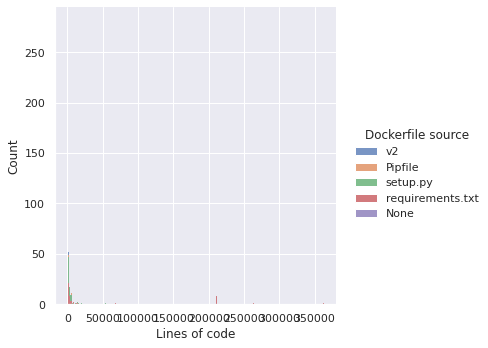

In [49]:
print("Datapoints: {}".format(len(executed()["loc"].dropna())))
g = sns.displot(executed(), x="loc", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 977


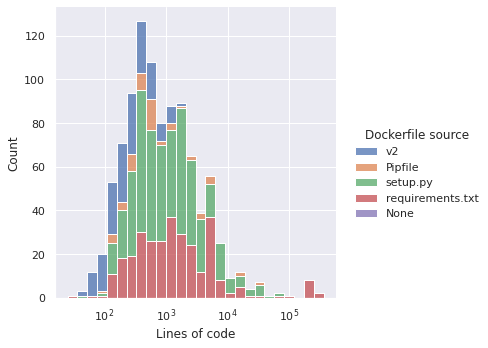

In [50]:
print("Datapoints: {}".format(len(executed()["loc"].dropna())))
g = sns.displot(executed(), x="loc", hue="dockerfile_source", hue_order=hor, log_scale=True, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Lines of code")

Datapoints: 977


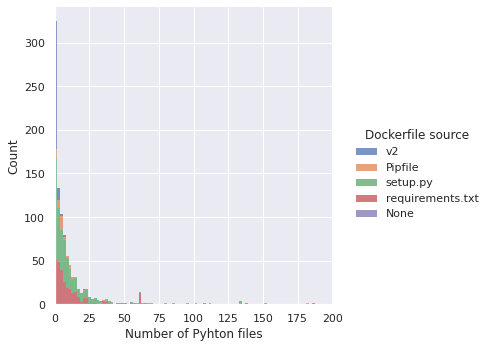

In [51]:
print("Datapoints: {}".format(len(executed()["num_impl_files"].dropna())))
g = sns.displot(executed(), x="num_impl_files", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of Pyhton files", xlim=(0,200))

Datapoints: 977


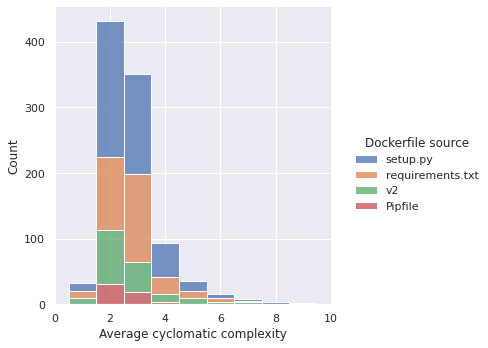

In [52]:
print("Datapoints: {}".format(len(executed()["average_complexity"].dropna())))
g = sns.displot(executed(), discrete=True, x="average_complexity", hue="dockerfile_source", multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Average cyclomatic complexity", xlim=(0,10))

Datapoints: 977


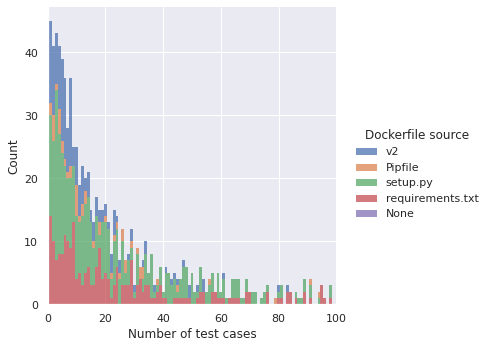

In [53]:
print("Datapoints: {}".format(len(executed()["testcase_count"].dropna())))
g = sns.displot(executed(), discrete=True, x="testcase_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of test cases", xlim=(0,100))

Datapoints: 608


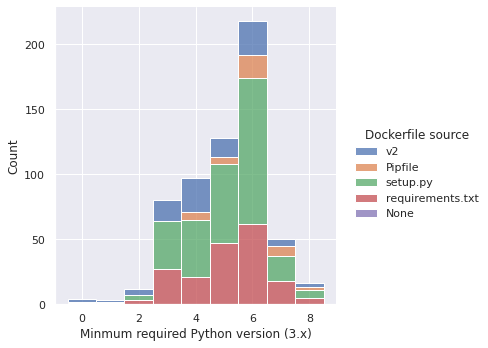

In [54]:
print("Datapoints: {}".format(len(executed()["min_python_version"].dropna())))
g = sns.displot(executed(), discrete=True, x="min_python_version", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Minmum required Python version (3.x)")

Datapoints: 968


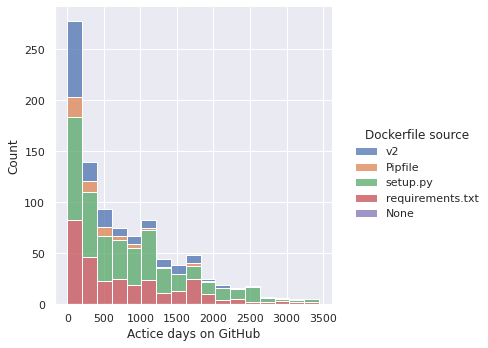

In [55]:
print("Datapoints: {}".format(len(executed()["github_repo_active_days"].dropna())))
g = sns.displot(executed(), x="github_repo_active_days", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Actice days on GitHub")

Datapoints: 968


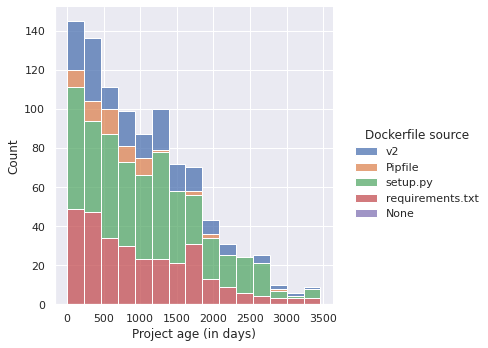

In [56]:
print("Datapoints: {}".format(len(executed()["github_repo_age"].dropna())))
g = sns.displot(executed(), x="github_repo_age", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Project age (in days)")

Another interesting property that can be inspected when comparing these groups is the number of pip and apt dependencies.
The graph for build but unsuccessful and successful proejects are shown down below

Datapoints: 977


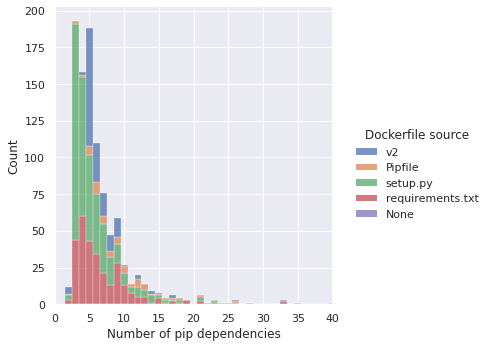

In [57]:
print("Datapoints: {}".format(len(executed()["pip_dependency_count"].dropna())))
g = sns.displot(executed(), x="pip_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack", discrete=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of pip dependencies", xlim=(0,40))

Datapoints: 977


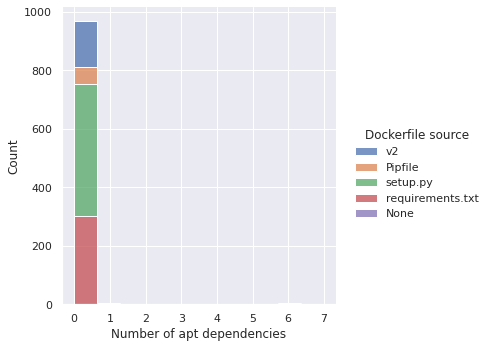

In [58]:
print("Datapoints: {}".format(len(executed()["apt_dependency_count"].dropna())))
g = sns.displot(executed(), x="apt_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of apt dependencies")

Now compare this to the number of dependencies, for which the testcases were successfully executed

Datapoints: 689


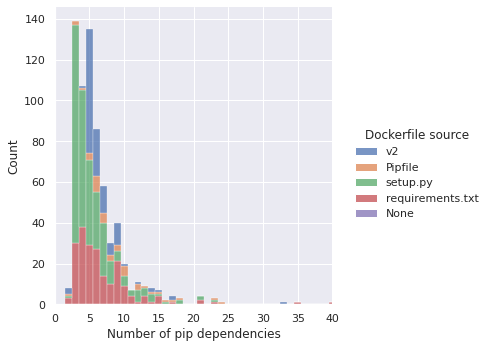

In [59]:
print("Datapoints: {}".format(len(success()["pip_dependency_count"].dropna())))
g = sns.displot(success(), x="pip_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack", discrete=True)
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of pip dependencies", xlim=(0,40))

Datapoints: 689


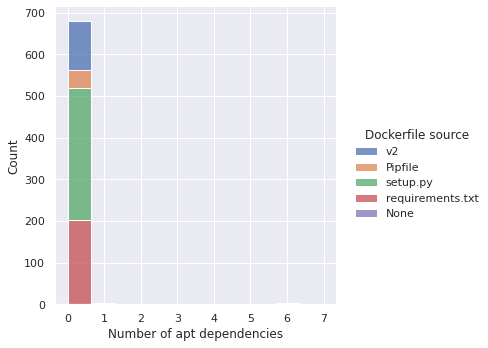

In [60]:
print("Datapoints: {}".format(len(success()["apt_dependency_count"].dropna())))
g = sns.displot(success(), x="apt_dependency_count", hue="dockerfile_source", hue_order=hor, multiple="stack")
g.legend.set_title(title="Dockerfile source")
g.set(xlabel="Number of apt dependencies")

In [61]:
print("LOC p-value: {}".format(mwu(executed_but_no_success()["loc"].dropna(), success()["loc"].dropna(), alternative="two-sided")[1]))
print("Num code files p-value: {}".format(mwu(executed_but_no_success()["num_impl_files"].dropna(), success()["num_impl_files"].dropna(), alternative="two-sided")[1]))
print("Complexity p-value: {}".format(mwu(executed_but_no_success()["average_complexity"].dropna(), success()["average_complexity"].dropna(), alternative="two-sided")[1]))
print("Testcase count p-value: {}".format(mwu(executed_but_no_success()["testcase_count"].dropna(), success()["testcase_count"].dropna(), alternative="two-sided")[1]))
print("Version p-value: {}".format(mwu(executed_but_no_success()["min_python_version"].dropna(), success()["min_python_version"].dropna(), alternative="two-sided")[1]))
print("Active days p-value: {}".format(mwu(executed_but_no_success()["github_repo_active_days"].dropna(), success()["github_repo_active_days"].dropna(), alternative="two-sided")[1]))
print("Age p-value: {}".format(mwu(executed_but_no_success()["github_repo_age"].dropna(), success()["github_repo_age"].dropna(), alternative="two-sided")[1]))
print("Pip p-value: {}".format(mwu(executed_but_no_success()["pip_dependency_count"].dropna(), success()["pip_dependency_count"].dropna(), alternative="two-sided")[1]))

LOC p-value: 0.17490936072858632
Num code files p-value: 0.43928850655354923
Complexity p-value: 0.8603477837157543
Testcase count p-value: 0.7424639098895269
Version p-value: 0.8736310385977339
Active days p-value: 0.041887037291855396
Age p-value: 0.06378885692545165
Pip p-value: 0.42249961187159357
